#Skin Lesion Classification with Segmentation masks

In this notebook we will train classification models using RGB images + the segmentation masks as a 4th channel. This is an attempt to inject more information to the network about where the lesion is.

• Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 • Tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter

* Check GPU type

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun 26 16:38:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |   1793MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Libraries**



In this section we import the packages and libraries for future use

In [ ]:
!pip install opencv-python-headless==4.5.2.52

!pip install git+https://github.com/albumentations-team/albumentations

In [ ]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps 
from skimage import io
from typing import Optional, Sequence
import copy
import time
import logging
import sys

# Sci-kit learn
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score
from sklearn.utils import class_weight

#Pytorch 
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import albumentations as A

# Some progress bar libraries
from tqdm import tqdm

In [ ]:
import cv2

# **Helper functions**

In this section we define different utils/helper function that will be usefull for the rest of the notebook

##  *Visualization*

In [ ]:
# A Function that uses Matplotlib's PyPlot to show an image stored in a pytorch tensor 
def imshow(inp, title=None, mask = False):
    """Imshow for Tensor.
       A Function that uses Matplotlib's PyPlot to show an image stored in a pytorch tensor 
       inputs: inp => image stored in tensor 
               title => title to be displayed with the image 
       returns: None

    """
    inp = inp.numpy().transpose((1, 2, 0))
    if not mask:
      mean = [0.7079, 0.5916, 0.5469]# mean
      std = [0.0937, 0.1113, 0.1257]# Standard deviation
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
# A function that shows a set of images with their correct labels and model's predictions
def visualize_model(model, loader, device, num_images=6):
      """Imshow for Tensor.
       Function to visualize some images and their predictions with the corresponding ground truth labels
       inputs: model => model  to predict the classes  
               loader => PyTorch dataloader to get the images 
               device => CUDA or CPU
               num_images => the number of images to show
       returns: None

    """
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for idx, batch in enumerate(loader):
              inputs = batch["image"].to(device)
              labels = batch["label"].to(device)

              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)

              for j in range(inputs.size()[0]):
                  images_so_far += 1
                  imshow(inputs.cpu().data[j][0:3, :, :]) # take just the first 3 channels
                  print(f'Actual: {labels[j]}, predicted: {preds[j]}')

                  if images_so_far == num_images:
                      model.train(mode=was_training)
                      return
        model.train(mode=was_training)

## Focal Loss

In [ ]:
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=-1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

## Models

In this function, a DenseNet121 model is created from torchvision.models. Then 2 modifications are applied: 


*   The first layer is substituted with a conv layer that takes 4-channel input. The pre-trained weights of the old conv layer are then copied back to the first 3-channels of the new layer whereas the weights for the 4th channel are randomly initialized.
*   The final layer (classifier) is modified to have 3 output neurones instead of 1000. 



In [ ]:
from torch.autograd import Variable

In [ ]:
def make_densenet(pretrained = True):
  """ Function to create a DenseNet model with 3 output neurones and 4-channel input
      inputs: pretrained => if True the pretrained model weights are loaded
      outputs: model => the DenseNet model
  """
  model = models.densenet121(pretrained=pretrained)

  # modify the first layer to take 4 channel images instead of 3 
  # copy the pretrained weights of the RGB channels back to the new first layer
  layer1 = model.features.conv0
  weight1 = model.features.conv0.weight.clone()
  new_first_layer  = nn.Conv2d(in_channels= 4, 
                        out_channels = layer1.out_channels, 
                        kernel_size = layer1.kernel_size, 
                        stride = layer1.stride, 
                        padding = layer1.padding,
                        bias = layer1.bias).requires_grad_()
  new_first_layer.weight[:,:3,:,:].data[...] =  Variable(weight1, requires_grad=True)
  model.features.conv0 = new_first_layer

  # Modify the output layer to 3 classes instead of 1000
  num_ftrs = model.classifier.in_features
  model.classifier = nn.Linear(num_ftrs, 3)
  model = model.to(DEVICE)
  
  return model

## Training

In [ ]:
# training function (same as used in Stage 1)
def train_model(model, # model to be trained
                dataloaders, #train  and val dataloaders
                criterion, # objective function
                optimizer, # optimization algorithm 
                scheduler, # learning rate scheduler 
                early_stop_patience=10, # when to stop training if the val loss does not improve
                num_epochs=25, # maximum number of epochs 
                writer_path= ''): # tensorbard writing path
    since = time.time()

    writers = {
        'val': SummaryWriter(writer_path + '/log_val'),
        'train': SummaryWriter(writer_path + '/log')
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e8
    best_bma = 0.0
    early_stop_c = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_labels = []
            running_preds = []

            # Iterate over data.
            for batch in dataloaders[phase]:

                inputs = batch["image"].to(DEVICE)
                labels = batch["label"].to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_labels = running_labels + labels.int().cpu().tolist()
                running_preds = running_preds + preds.int().cpu().tolist()


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = accuracy_score(running_labels, running_preds)
            epoch_bma = balanced_accuracy_score(running_labels, running_preds)

            if phase == 'val':
              scheduler.step(epoch_loss)
              lr_ = optimizer.param_groups[0]['lr']
              writers['train'].add_scalar('info/lr', lr_, epoch)

            # print(f'{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, BMA: {epoch_bma:.4f}')
            logging.info( '%s epoch %d : loss : %.4f, acc: %.4f, bma: %.4f' %
                (phase, epoch+1, epoch_loss, epoch_acc, epoch_bma))
            
            writers[phase].add_scalar('info/loss', epoch_loss, epoch)
            writers[phase].add_scalar('info/acc', epoch_acc, epoch)
            writers[phase].add_scalar('info/bma', epoch_bma, epoch)

            # deep copy the model
            if phase == 'val':
              if epoch_loss < best_loss:
                best_loss = epoch_loss
                early_stop_c = 0
              else:
                early_stop_c += 1

              if epoch_bma > best_bma:
                best_bma = epoch_bma
                best_model_wts = copy.deepcopy(model.state_dict())

        if early_stop_c > early_stop_patience:
            print(f'EARLY STOP AFTER {epoch + 1} EPOCHS')         
            break   

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:4f}')
    print(f"Best val BMA: {best_bma}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    writers['train'].close()
    writers['val'].close()
    return model

## Testing

In [ ]:
# this function takes a model, a loss function and a dataloader and it calculates
# the loss, accracy and the bma achieved by the given model on the given test loader
def test_model(model, loader, device, criterion):
    """ Function to test a model's performance on the test set 
        inputs: model => model to be tested
                loader => test loader 
                device => Cuda or CPU
                criterion => objective function

        returns: test loss, test accuracy and test bma
    """ 
    since = time.time()

    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    running_labels = []
    running_preds = []

    # Iterate over data.
    with torch.no_grad():
        for batch in loader:
            inputs = batch["image"].to(DEVICE)
            labels = batch["label"].to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            running_labels = running_labels + labels.int().cpu().tolist()
            running_preds = running_preds + preds.int().cpu().tolist()

        test_loss = running_loss / dataset_sizes['test'] 
        test_bma = balanced_accuracy_score(running_labels, running_preds)
        test_acc = accuracy_score(running_labels, running_preds)
        print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}, BMA: {test_bma:.4f}')
    
        time_elapsed = time.time() - since
        print(f'Testing complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        model.train()

        return test_loss, test_acc, test_bma

In [ ]:
# same as test_model but it returns the labels, prediction and probabilities of the model on the loader passed as parameters
def test_model2(model, loader, device= 'cuda'):
    """ Function to obtain the probabilities and predictions of a model on the test loader
        inputs: model => model to be tested
                loader => test loader 
                device => Cuda or CPU
                criterion => objective function

        returns: probabilitis, predictions and labels of the images in loader
    """
    since = time.time()

    model.eval()   # Set model to evaluate mode

    running_labels = []
    running_preds = []
    running_outputs = np.empty((0, 3), dtype = np.float32)

    # Iterate over data.
    with torch.no_grad():
        for batch in loader:
            inputs = batch["image"].to(DEVICE)
            labels = batch["label"].to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_labels = running_labels + labels.int().cpu().tolist()
            running_preds = running_preds + preds.int().cpu().tolist()
            running_outputs = np.concatenate((running_outputs,  F.softmax(outputs).detach().cpu().numpy()), axis=0)



    return running_outputs, running_labels, running_preds

In [ ]:
# a function to plot the roc curves of each class using one-versus-rest approach
def plot_roc(labels, predictions, n_classes):
    fpr = dict() # false positive rates
    tpr = dict() # true positive rates
    roc_auc = dict() # dict to store AUCs
    for i in range(n_classes):
        actuals = (np.array(labels) == i).astype(np.uint8) # 1 if the label is class i, 0 otherwise
        fpr[i], tpr[i], _ = roc_curve(actuals, predictions[:, i]) # sklearn's roc_curve is used to calculate TPRs and FPRs
        roc_auc[i] = auc(fpr[i], tpr[i]) # calculate the AUC value for class i

    # draw the curves
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                          ''.format(class_names[i], roc_auc[i]))  # roc_auc_score

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

# **Dataset Definition and Split**

## Sampler

In [ ]:
from typing import Callable
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices: a list of indices
        num_samples: number of samples to draw
        callback_get_label: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices: list = None, num_samples: int = None, callback_get_label: Callable = None,
                 replacement=True):
        # if indices is not provided, all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) if num_samples is None else num_samples

        self.replacement = replacement

        # distribution of classes in the dataset
        df = pd.DataFrame()
        df["label"] = self._get_labels(dataset)
        df.index = self.indices
        df = df.sort_index()

        label_to_count = df["label"].value_counts()

        weights = 1.0 / label_to_count[df["label"]]

        self.weights = torch.DoubleTensor(weights.to_list())

    def _get_labels(self, dataset):
        if self.callback_get_label:
            return self.callback_get_label(dataset)
        elif isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels.tolist()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return [x[1] for x in dataset.imgs]
        elif isinstance(dataset, torchvision.datasets.DatasetFolder):
            return dataset.samples[:][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[:][1]
        elif isinstance(dataset, torch.utils.data.Dataset):
            return dataset.get_labels()
        else:
            print('Not implemented for this type of dataset.')

    def __iter__(self):
        return (self.indices[i] for i in
                torch.multinomial(self.weights, self.num_samples, replacement=self.replacement))

    def __len__(self):
        return self.num_samples

## Custom ISIC2017 Dataset

Next, we create a custom Pytorch dataset class for ISIC2017 data

In [ ]:
# Parameters 
# Please change to the corresponding path if not the same in your device
train_img_folder = '/content/drive/MyDrive/Dataset/images'
val_img_folder = '/content/drive/MyDrive/Dataset/validation_images'
test_img_folder = '/content/drive/MyDrive/Dataset/test_images'

train_seg_folder = '/content/drive/MyDrive/seg_results/train'
val_seg_folder = '/content/drive/MyDrive/seg_results/val'
test_seg_folder = '/content/drive/MyDrive/seg_results/test'

train_csv_path = '/content/drive/MyDrive/Dataset/train_2000.csv'
val_csv_path = '/content/drive/MyDrive/Dataset/validation_150.csv'
test_csv_path = '/content/drive/MyDrive/Dataset/test_600.csv'


dataset_sizes = {
    'train': 2000,
    'val':150,
    'test':600
}

class_names = {
    0: "Benign",
    1: "Melanoma",
    2: "seborrheic Keratosis"
}

In [ ]:
class ISIC2017Dataset(Dataset):
    """ISIC2017 dataset"""

    def __init__(self, csv_file, image_folder, segmentation_folder, img_transform=None, mask_transform = None, augment = False):
        """
        Args:
            csv_file (string): Path to the csv file with image paths & classification labels.
            image_folder (string): Path to the folder where the PNG images are located
            segmentation_folder (string): Path to the folder where the segmentation labels are located
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file).drop("Unnamed: 0", axis = 1) # pandas dataframe containing the image IDs
        self.labels = self.df["label"].values.tolist()
        self.image_folder = image_folder # path to the folder containing the original images 
        self.segmentation_folder = segmentation_folder # path to the folder containing the GT images
        self.img_transform = img_transform # image transform for the images 
        self.mask_transform = mask_transform # image transform for the masks
        self.augment = augment # whether to perform data augmentation or not         

    def __len__(self):
        return len(self.labels) # return the number of images in the dataset

    def get_labels(self):
        return self.labels # return the number of images in the dataset

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = '/' + self.df.iloc[idx]['image_id'] # obtain image file name start 
        img_path = self.image_folder+img_id + '.jpg' # file path of the original image 
        mask_path = self.segmentation_folder+ img_id + '_mask.png' # file path of the mask
        
        image = Image.open(img_path)  # open the original image as RGB
        mask = Image.open(mask_path) # open the segmentation mask 
        label = self.df.iloc[idx]['label']

        if self.augment:
          image_np = np.array(image).astype(np.uint8)
          mask_np = np.array(mask).astype(np.uint8)
        
          aug_transform = A.Compose([
                                          A.SmallestMaxSize(max_size=260),
                                          A.RandomResizedCrop(height=256, width=256, p = 0.7, scale=(0.4, 1.0), ratio=(0.75, 4/3)),
                                          A.Affine(scale=(0.8, 1.2), rotate=(0.0, 90.0), shear=(0.0,20.0), mode=1, p=0.8),
                                          A.Flip(p=1.0),
                                          A.ColorJitter(brightness=[0.9, 1.1], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=0.1, p=0.6),
                                 ]
          )

          augmentations = aug_transform(image=image_np, mask=mask_np)
          image = Image.fromarray(augmentations["image"])
          mask = Image.fromarray(augmentations["mask"]>0.0)

        # If a transform is provided apply it (Preprocessing)
        if self.img_transform:
            image = self.img_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        # add the mask as a 4th channel to the image
        img_mask = torch.cat((image, mask), 0)

        # return the image, the segmentation label
        return {'image': img_mask,
                'label': label}

## Prepare data

In [ ]:
def get_samples_count(y, sampling_technique):
        """
          function to find the number of samples in the balanced trainning loader
          inputs: y => list of labels 
                  sampling technique => 'mean' or 'over' or 'under'

          returns: mean_samples = 
                                  mean of the number of samples in each class if 'mean'
                                  #samples in the majority class for each class if 'over'
                                  #samples in the minority class for each class if 'under' 
        """
        unique, counts = np.unique(y, return_counts=True) # number of samples in each class
       
        if sampling_technique == 'mean':
            mean_samples = np.mean(counts)*3 # return the mean of samples from each class 
        elif sampling_technique == 'over':
            mean_samples = np.max(counts)*3 # return the #samples in the majority class for each class 
        elif sampling_technique == 'under':
            mean_samples = np.min(counts)*3 # return the #samples in the minority class for each class
        else:
            raise Exception("Error: Sampling Technique not implemented")
        return int(mean_samples)

In [ ]:
# Parameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used

NEW_SIZE = 256

# Calculated from the original training set 
mu = [0.7079, 0.5916, 0.5469]# mean
std = [0.0937, 0.1113, 0.1257]# Standard deviation

TRAIN_BATCH_SIZE = 10
TEST_BATCH_SIZE = 32
VAL_BATCH_SIZE = 32
NUM_WORKERS = 2

#### Data Transforms

In [ ]:
# Transforms for preprocessing, we will use the same for all datasets here
img_transforms = transforms.Compose([
                                      transforms.Resize(NEW_SIZE+4),
                                      transforms.CenterCrop(NEW_SIZE),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean= mu, std=std)
                                  ])



mask_transforms = transforms.Compose([
                                      transforms.Resize(NEW_SIZE+4),
                                      transforms.CenterCrop(NEW_SIZE),
                                      transforms.ToTensor(),
                                    ])

#### Datasets 

In [ ]:
isic_train = ISIC2017Dataset(csv_file =train_csv_path,
                             image_folder = train_img_folder,
                             segmentation_folder = train_seg_folder,
                             img_transform= img_transforms,
                             mask_transform= mask_transforms, 
                             augment = True)


isic_val = ISIC2017Dataset(csv_file=val_csv_path, 
                            image_folder= val_img_folder, 
                            segmentation_folder= val_seg_folder,
                             img_transform= img_transforms,
                             mask_transform= mask_transforms, 
                            augment = False)

isic_test = ISIC2017Dataset(csv_file=test_csv_path, 
                            image_folder= test_img_folder, 
                            segmentation_folder= test_seg_folder,
                            img_transform= img_transforms,
                            mask_transform= mask_transforms,
                            augment = False)

#### Data Loaders

In [ ]:
class_weights = torch.tensor([0.4859, 1.7825, 2.6247]).to(DEVICE)
# Balanced training dataloader
mean_samples = get_samples_count(isic_train.get_labels(), 'under') # perform undersampling 
data_sampler = ImbalancedDatasetSampler(isic_train, indices=None, num_samples=mean_samples, replacement = True)
train_loader_balanced = DataLoader(isic_train, sampler=data_sampler, num_workers=NUM_WORKERS,
                             batch_size=TRAIN_BATCH_SIZE) 

In [ ]:
train_loader = DataLoader(isic_train, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(isic_val, batch_size=VAL_BATCH_SIZE, num_workers=NUM_WORKERS)
test_loader = DataLoader(isic_test, batch_size=TEST_BATCH_SIZE, num_workers=NUM_WORKERS)

In [ ]:
dataloaders = {"train": train_loader,
              "val": val_loader}

# dataloader with balanced number of samples in each class
dataloaders_balanced = {"train": train_loader_balanced,
                        "val": val_loader}

In [ ]:
# Get a batch of training data
batch = next(iter(train_loader))
data = batch['image']
label = batch['label']

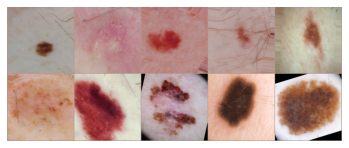

In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(data, nrow = 5)

imshow(out[0:3, :, :])

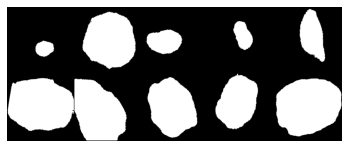

In [ ]:
masks = out[3, : , : ]*255
masks = masks.unsqueeze(0)
masks = torch.cat((masks, masks, masks), 0)
masks.shape
imshow(masks, mask= True)

# Segmentation as a 4th channel

#### With Focal Loss

##### With SGD

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/Tensorboard_class/densenet/densenest_fl_sgd_ha.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/Tensorboard_class/densenet/densenet'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 5
ES_PATIENCE = 10
EPOCHS = 100
WD = 1e-8

In [ ]:
densenet = make_densenet(True)

criterion = FocalLoss(alpha = class_weights, gamma = 2.0, size_average= True)

optimizer = optim.SGD(densenet.parameters(), lr = LR, weight_decay=WD, momentum = 0.9)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.25, mode="min")

In [ ]:
logging.info('Model:Densenet, LR: 1e-4, LR patience = 5, loss: Focal, optim: SGD, lr_sched: ReduceOnPlat, WD = 1e-8, momentum = 0.9')

In [ ]:
densenet = train_model(densenet, dataloaders, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 0.4848, acc: 0.3995, bma: 0.4033
val epoch 1 : loss : 0.6082, acc: 0.4733, bma: 0.4309

Epoch 2/100
----------
train epoch 2 : loss : 0.4264, acc: 0.5000, bma: 0.5017
val epoch 2 : loss : 0.5259, acc: 0.5600, bma: 0.5536

Epoch 3/100
----------
train epoch 3 : loss : 0.3755, acc: 0.5485, bma: 0.5771
val epoch 3 : loss : 0.5112, acc: 0.5267, bma: 0.5149

Epoch 4/100
----------
train epoch 4 : loss : 0.3676, acc: 0.5640, bma: 0.5982
val epoch 4 : loss : 0.4911, acc: 0.6000, bma: 0.5661

Epoch 5/100
----------
train epoch 5 : loss : 0.3587, acc: 0.5830, bma: 0.6115
val epoch 5 : loss : 0.4718, acc: 0.6333, bma: 0.6221

Epoch 6/100
----------
train epoch 6 : loss : 0.3454, acc: 0.6025, bma: 0.6208
val epoch 6 : loss : 0.4390, acc: 0.6400, bma: 0.6295

Epoch 7/100
----------
train epoch 7 : loss : 0.3290, acc: 0.6090, bma: 0.6521
val epoch 7 : loss : 0.4079, acc: 0.6933, bma: 0.6684

Epoch 8/100
----------
train epoch 8 : loss : 0.3221, acc: 0.6

In [ ]:
torch.save(densenet.state_dict(), '/content/drive/MyDrive/classification_checkpoints/4c_densenet_fl_sgd.pth')

Test

In [ ]:
densenet.load_state_dict(torch.load( '/content/drive/MyDrive/classification_checkpoints/4c_densenet_fl_sgd.pth'))

<All keys matched successfully>

In [ ]:
test_loss, test_acc, test_bma = test_model(densenet, test_loader, DEVICE, criterion)

Test Loss: 0.3245 Acc: 0.6067, BMA: 0.6690
Testing complete in 12m 6s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Show some results

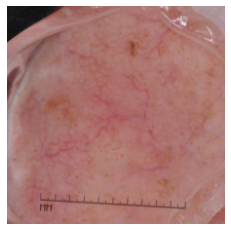

Actual: 2, predicted: 1


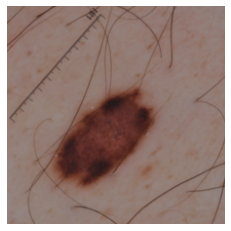

Actual: 0, predicted: 0


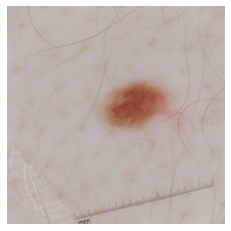

Actual: 0, predicted: 0


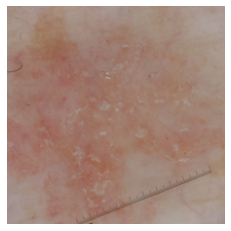

Actual: 2, predicted: 2


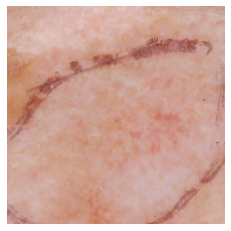

Actual: 2, predicted: 2


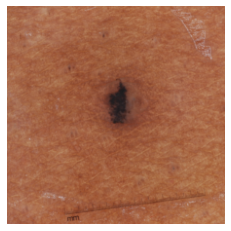

Actual: 0, predicted: 0


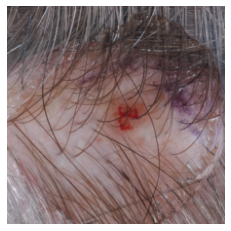

Actual: 0, predicted: 0


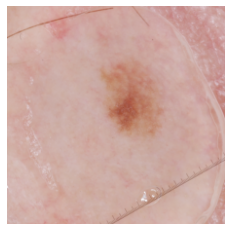

Actual: 0, predicted: 2


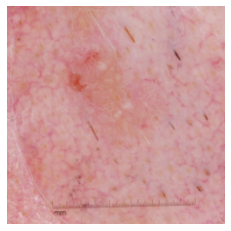

Actual: 2, predicted: 2


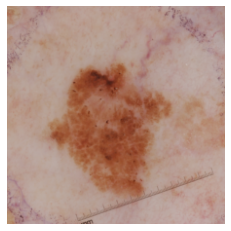

Actual: 2, predicted: 1


In [ ]:
visualize_model(densenet, test_loader, DEVICE, num_images=10)

##### With ADAM

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/Tensorboard_class/densenet/4c_densenest_fl_adam.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/Tensorboard_class/densenet/densenet'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 5
ES_PATIENCE = 10

EPOCHS = 100
WD = 1e-8

In [ ]:
densenet = make_densenet(True)

criterion = FocalLoss(alpha = class_weights, gamma = 2.0, size_average= True)

optimizer = optim.Adam(densenet.parameters(), lr = LR, weight_decay=WD)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.5, mode="min")

In [ ]:
logging.info('Model:Densenet, LR: 1e-4, LR patience = 5, loss: Focal, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8')

In [ ]:
densenet = train_model(densenet, dataloaders, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 0.4032, acc: 0.4985, bma: 0.5367
val epoch 1 : loss : 0.4099, acc: 0.6733, bma: 0.6377

Epoch 2/100
----------
train epoch 2 : loss : 0.3288, acc: 0.6080, bma: 0.6350
val epoch 2 : loss : 0.3760, acc: 0.7400, bma: 0.7020

Epoch 3/100
----------
train epoch 3 : loss : 0.2970, acc: 0.6345, bma: 0.6795
val epoch 3 : loss : 0.2853, acc: 0.7333, bma: 0.7292

Epoch 4/100
----------
train epoch 4 : loss : 0.3063, acc: 0.6210, bma: 0.6515
val epoch 4 : loss : 0.3386, acc: 0.7000, bma: 0.6741

Epoch 5/100
----------
train epoch 5 : loss : 0.2681, acc: 0.6580, bma: 0.6969
val epoch 5 : loss : 0.3404, acc: 0.7267, bma: 0.6770

Epoch 6/100
----------
train epoch 6 : loss : 0.2520, acc: 0.6710, bma: 0.7129
val epoch 6 : loss : 0.2535, acc: 0.7200, bma: 0.7585

Epoch 7/100
----------
train epoch 7 : loss : 0.2407, acc: 0.6755, bma: 0.7127
val epoch 7 : loss : 0.3388, acc: 0.7067, bma: 0.6852

Epoch 8/100
----------
train epoch 8 : loss : 0.2378, acc: 0.6

In [ ]:
torch.save(densenet.state_dict(), '/content/drive/MyDrive/classification_checkpoints/4c_densenet_fl_adam.pth')

Test

In [ ]:
densenet.load_state_dict(torch.load( '/content/drive/MyDrive/classification_checkpoints/4c_densenet_fl_adam.pth'))

<All keys matched successfully>

In [ ]:
test_loss, test_acc, test_bma = test_model(densenet, test_loader, DEVICE, criterion)

Test Loss: 0.3029 Acc: 0.7167, BMA: 0.7352
Testing complete in 5m 24s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Show some results

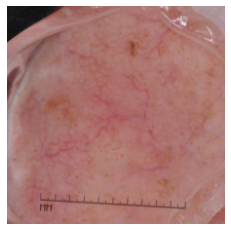

Actual: 2, predicted: 0


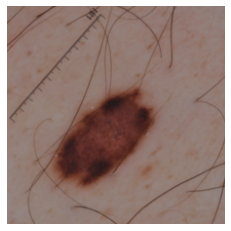

Actual: 0, predicted: 1


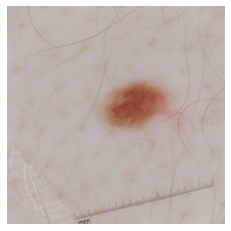

Actual: 0, predicted: 0


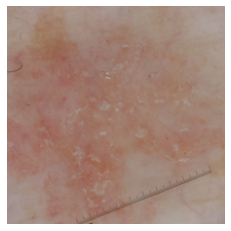

Actual: 2, predicted: 2


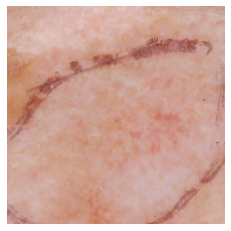

Actual: 2, predicted: 2


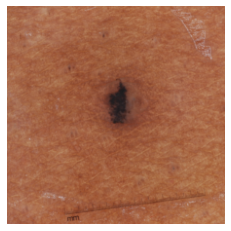

Actual: 0, predicted: 0


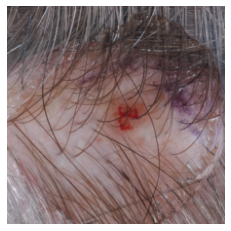

Actual: 0, predicted: 2


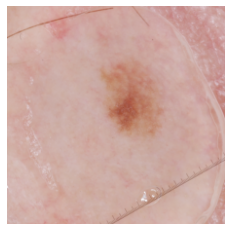

Actual: 0, predicted: 0


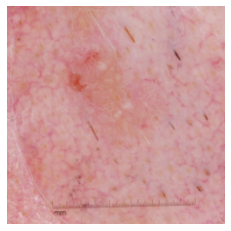

Actual: 2, predicted: 2


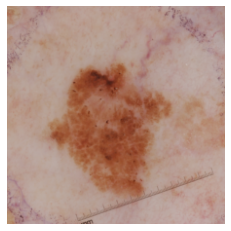

Actual: 2, predicted: 1


In [ ]:
visualize_model(densenet, test_loader, DEVICE, num_images=10)

#### With Weighted Cross Entropy 

##### With SGD

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/Tensorboard_class/densenet/4c_densenest_wce_sgd.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/Tensorboard_class/densenet'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 5
ES_PATIENCE = 10

EPOCHS = 100
WD = 1e-8

In [ ]:
densenet = make_densenet(True)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.SGD(densenet.parameters(), lr = LR, weight_decay=WD, momentum = 0.9)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.5, mode="min")

In [ ]:
logging.info('Model:Densenet, LR init: 1e-4, LR patience = 7, loss: WCE, optim: SGD, lr_sched: ReduceOnPlat, WD = 1e-8, momentum = 0.9')

In [ ]:
densenet = train_model(densenet, dataloaders, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 1.0346, acc: 0.5040, bma: 0.4535
val epoch 1 : loss : 0.9463, acc: 0.5667, bma: 0.5427

Epoch 2/100
----------
train epoch 2 : loss : 0.9045, acc: 0.5960, bma: 0.5698
val epoch 2 : loss : 0.8404, acc: 0.6533, bma: 0.6686

Epoch 3/100
----------
train epoch 3 : loss : 0.8457, acc: 0.6125, bma: 0.6233
val epoch 3 : loss : 0.7916, acc: 0.6533, bma: 0.6181

Epoch 4/100
----------
train epoch 4 : loss : 0.8221, acc: 0.6365, bma: 0.6331
val epoch 4 : loss : 0.7146, acc: 0.6400, bma: 0.6283

Epoch 5/100
----------
train epoch 5 : loss : 0.7920, acc: 0.6485, bma: 0.6448
val epoch 5 : loss : 0.6714, acc: 0.7067, bma: 0.6833

Epoch 6/100
----------
train epoch 6 : loss : 0.7434, acc: 0.6695, bma: 0.6658
val epoch 6 : loss : 0.6099, acc: 0.6800, bma: 0.6803

Epoch 7/100
----------
train epoch 7 : loss : 0.7276, acc: 0.6665, bma: 0.6738
val epoch 7 : loss : 0.6077, acc: 0.7267, bma: 0.7276

Epoch 8/100
----------
train epoch 8 : loss : 0.7369, acc: 0.6

Test

In [ ]:
test_loss, test_acc, test_bma = test_model(densenet, test_loader, DEVICE, criterion)

Test Loss: 0.6772 Acc: 0.7133, BMA: 0.7358
Testing complete in 5m 9s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Test loss: 0.6772, acc: 0.7133, bma: 0.7358


Show some results

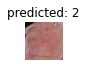

Actual: 2, predicted: 2


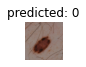

Actual: 0, predicted: 0


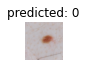

Actual: 0, predicted: 0


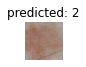

Actual: 2, predicted: 2


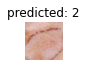

Actual: 2, predicted: 2


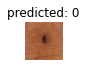

Actual: 0, predicted: 0


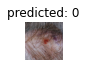

Actual: 0, predicted: 0


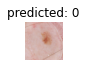

Actual: 0, predicted: 0


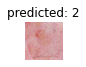

Actual: 2, predicted: 2


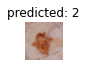

Actual: 2, predicted: 2


In [ ]:
visualize_model(densenet, test_loader, DEVICE, num_images=10)

##### With ADAM

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/4 channel classification/4c_densenest_wce_adam.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/4 channel classification'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 10

EPOCHS = 100
WD = 1e-8

In [ ]:
densenet = make_densenet(True)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(densenet.parameters(), lr = LR, weight_decay=WD)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.5, mode="min")

In [ ]:
logging.info('Model:Densenet, LR: 1e-4, LR patience = 7, loss: WCE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8')

Model:Densenet, LR: 1e-4, LR patience = 7, loss: WCE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8


In [ ]:
densenet = train_model(densenet, dataloaders, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 0.9049, acc: 0.5470, bma: 0.5718
val epoch 1 : loss : 0.6507, acc: 0.7267, bma: 0.7322

Epoch 2/100
----------
train epoch 2 : loss : 0.7795, acc: 0.6355, bma: 0.6478
val epoch 2 : loss : 0.6552, acc: 0.7200, bma: 0.7211

Epoch 3/100
----------
train epoch 3 : loss : 0.7449, acc: 0.6860, bma: 0.6713
val epoch 3 : loss : 0.6287, acc: 0.6867, bma: 0.6746

Epoch 4/100
----------
train epoch 4 : loss : 0.6718, acc: 0.6930, bma: 0.7035
val epoch 4 : loss : 0.6497, acc: 0.7133, bma: 0.6739

Epoch 5/100
----------
train epoch 5 : loss : 0.6689, acc: 0.7035, bma: 0.7107
val epoch 5 : loss : 0.5429, acc: 0.7333, bma: 0.7292

Epoch 6/100
----------
train epoch 6 : loss : 0.6266, acc: 0.7130, bma: 0.7245
val epoch 6 : loss : 0.5159, acc: 0.7533, bma: 0.7488

Epoch 7/100
----------
train epoch 7 : loss : 0.6212, acc: 0.7245, bma: 0.7364
val epoch 7 : loss : 0.4888, acc: 0.7667, bma: 0.7574

Epoch 8/100
----------
train epoch 8 : loss : 0.5885, acc: 0.7

Test

In [ ]:
densenet.load_state_dict(torch.load('/content/drive/MyDrive/Project Report/Checkpoints/Classification/4c_densenet_wce_adam_best.pth'))

In [ ]:
test_loss, test_acc, test_bma = test_model(densenet, test_loader, DEVICE, criterion)

Test Loss: 0.6644 Acc: 0.7767, BMA: 0.7766
Testing complete in 5m 8s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Test loss: 0.6644, acc: 0.7767, bma: 0.7766


Show some results

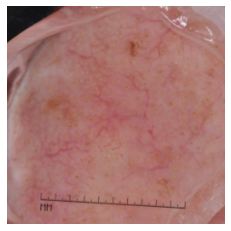

Actual: 2, predicted: 2


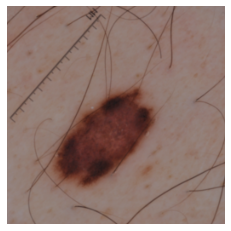

Actual: 0, predicted: 1


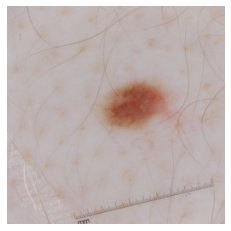

Actual: 0, predicted: 0


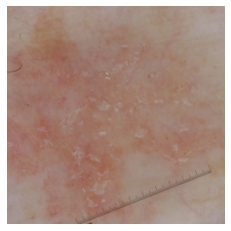

Actual: 2, predicted: 2


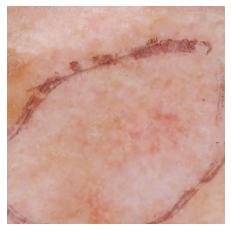

Actual: 2, predicted: 2


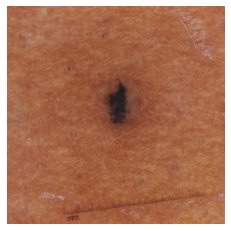

Actual: 0, predicted: 0


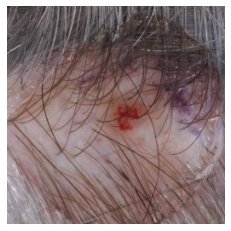

Actual: 0, predicted: 2


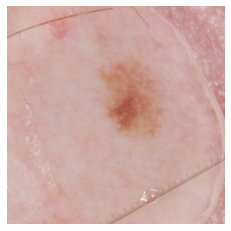

Actual: 0, predicted: 0


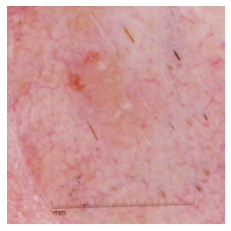

Actual: 2, predicted: 2


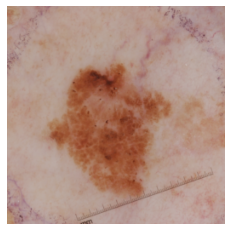

Actual: 2, predicted: 2


In [ ]:
visualize_model(densenet, test_loader, DEVICE, num_images=10)

#### With Cross Entropy + sampling

##### With SGD

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/4 channel classification/4c_densenest_ce_sgd.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/4 channel classification'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 5
ES_PATIENCE = 10

EPOCHS = 100
WD = 1e-8

In [ ]:
densenet = make_densenet(True)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(densenet.parameters(), lr = LR, weight_decay=WD, momentum = 0.9)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.1, mode="min")

In [ ]:
logging.info('With Mask: Model:Densenet, LR init: 1e-4, LR patience = 5, loss: CE, optim: SGD, lr_sched: ReduceOnPlat, WD = 1e-8, momentum = 0.9')

With Mask: Model:Densenet, LR init: 1e-4, LR patience = 5, loss: CE, optim: SGD, lr_sched: ReduceOnPlat, WD = 1e-8, momentum = 0.9


In [ ]:
densenet = train_model(densenet, dataloaders_balanced, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 0.4193, acc: 0.3950, bma: 0.3967
val epoch 1 : loss : 1.0458, acc: 0.4800, bma: 0.4720

Epoch 2/100
----------
train epoch 2 : loss : 0.3898, acc: 0.4764, bma: 0.4752
val epoch 2 : loss : 0.9716, acc: 0.5467, bma: 0.4913

Epoch 3/100
----------
train epoch 3 : loss : 0.3585, acc: 0.5538, bma: 0.5502
val epoch 3 : loss : 0.9271, acc: 0.6067, bma: 0.5799

Epoch 4/100
----------
train epoch 4 : loss : 0.3579, acc: 0.5551, bma: 0.5584
val epoch 4 : loss : 0.8628, acc: 0.6267, bma: 0.5785

Epoch 5/100
----------
train epoch 5 : loss : 0.3395, acc: 0.5971, bma: 0.5965
val epoch 5 : loss : 0.7970, acc: 0.6667, bma: 0.6120

Epoch 6/100
----------
train epoch 6 : loss : 0.3362, acc: 0.5853, bma: 0.5873
val epoch 6 : loss : 0.7843, acc: 0.6600, bma: 0.6287

Epoch 7/100
----------
train epoch 7 : loss : 0.3192, acc: 0.6194, bma: 0.6220
val epoch 7 : loss : 0.7588, acc: 0.6733, bma: 0.6578

Epoch 8/100
----------
train epoch 8 : loss : 0.3133, acc: 0.6

In [ ]:
torch.save(densenet.state_dict(), '/content/drive/MyDrive/Project Report/Checkpoints/Classification/4c_densenet_ce_sgd.pth')

Test

In [ ]:
test_loss, test_acc, test_bma = test_model(densenet, test_loader, DEVICE, criterion)

Test Loss: 0.7587 Acc: 0.6617, BMA: 0.6992
Testing complete in 6m 39s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Test loss: 0.7587, acc: 0.6617, bma: 0.6992


Show some results

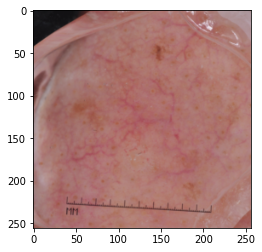

Actual: 2, predicted: 2


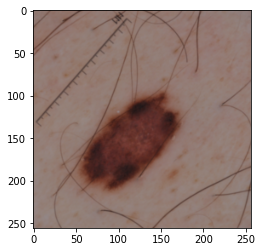

Actual: 0, predicted: 1


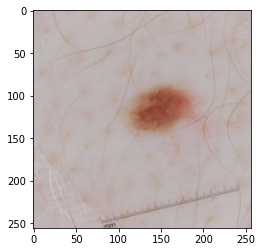

Actual: 0, predicted: 0


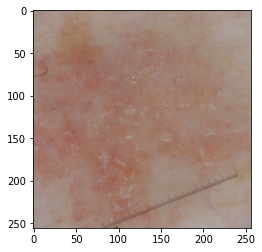

Actual: 2, predicted: 2


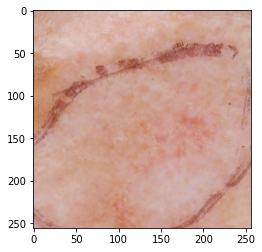

Actual: 2, predicted: 2


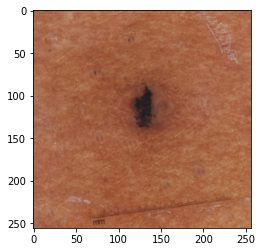

Actual: 0, predicted: 0


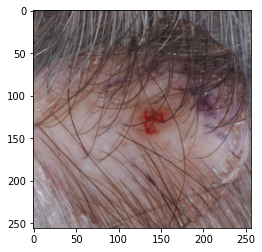

Actual: 0, predicted: 2


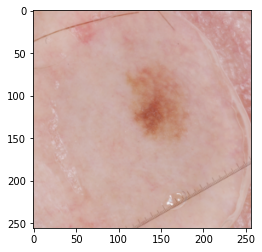

Actual: 0, predicted: 0


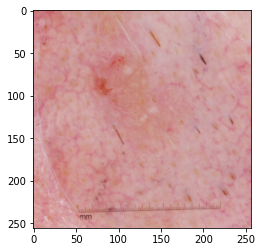

Actual: 2, predicted: 2


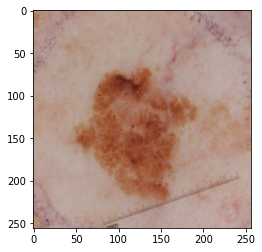

Actual: 2, predicted: 1


In [ ]:
visualize_model(densenet, test_loader, DEVICE, num_images=10)

##### With ADAM

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/4 channel classification/4c_densenest_ce_adam.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/4 channel classification'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 5
ES_PATIENCE = 10

EPOCHS = 100
WD = 1e-8

In [ ]:
densenet = make_densenet(True)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(densenet.parameters(), lr = LR, weight_decay=WD)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.1, mode="min")

In [ ]:
logging.info('Model:Densenet, LR init: 1e-4, LR patience = 5, loss: CE, optim: Adam, lr_sched: ReduceOnPlat, WD = 1e-8')

In [ ]:
densenet = train_model(densenet, dataloaders_balanced, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 0.3484, acc: 0.5682, bma: 0.5637
val epoch 1 : loss : 0.7240, acc: 0.6933, bma: 0.6479

Epoch 2/100
----------
train epoch 2 : loss : 0.2899, acc: 0.6562, bma: 0.6582
val epoch 2 : loss : 0.7126, acc: 0.6733, bma: 0.6819

Epoch 3/100
----------
train epoch 3 : loss : 0.2898, acc: 0.6667, bma: 0.6677
val epoch 3 : loss : 0.6294, acc: 0.7333, bma: 0.7255

Epoch 4/100
----------
train epoch 4 : loss : 0.2576, acc: 0.7034, bma: 0.7022
val epoch 4 : loss : 0.5825, acc: 0.7600, bma: 0.7690

Epoch 5/100
----------
train epoch 5 : loss : 0.2571, acc: 0.6811, bma: 0.6759
val epoch 5 : loss : 0.6368, acc: 0.7067, bma: 0.6579

Epoch 6/100
----------
train epoch 6 : loss : 0.2628, acc: 0.6864, bma: 0.6866
val epoch 6 : loss : 0.5511, acc: 0.7667, bma: 0.7232

Epoch 7/100
----------
train epoch 7 : loss : 0.2404, acc: 0.7060, bma: 0.7054
val epoch 7 : loss : 0.5273, acc: 0.7467, bma: 0.7377

Epoch 8/100
----------
train epoch 8 : loss : 0.2518, acc: 0.7

Test

In [ ]:
test_loss, test_acc, test_bma = test_model(densenet, test_loader, DEVICE, criterion)

Test Loss: 0.6546 Acc: 0.7383, BMA: 0.7288
Testing complete in 5m 4s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Test loss: 0.6546, acc: 0.7383, bma: 0.7288


Show some results

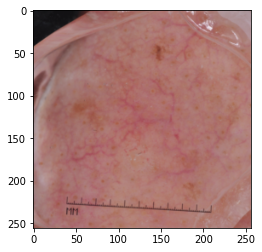

Actual: 2, predicted: 2


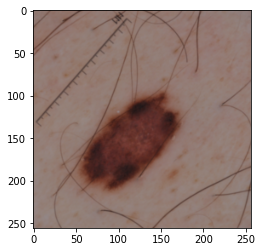

Actual: 0, predicted: 1


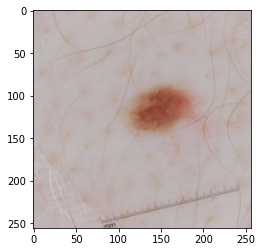

Actual: 0, predicted: 0


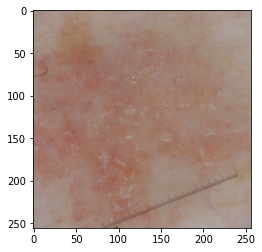

Actual: 2, predicted: 2


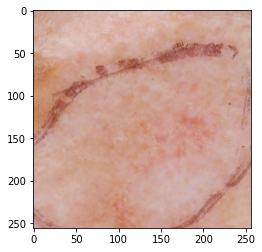

Actual: 2, predicted: 2


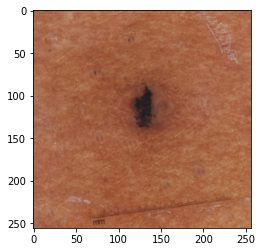

Actual: 0, predicted: 0


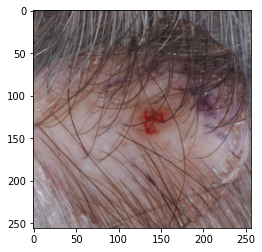

Actual: 0, predicted: 0


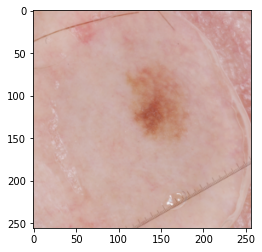

Actual: 0, predicted: 0


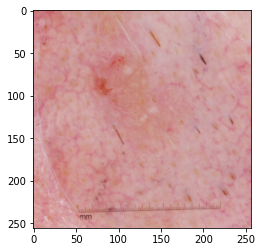

Actual: 2, predicted: 2


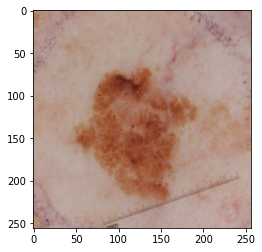

Actual: 2, predicted: 1


In [ ]:
visualize_model(densenet, test_loader, DEVICE, num_images=10)

In [ ]:
torch.save(densenet.state_dict(), '/content/drive/MyDrive/Project Report/Checkpoints/Classification/4c_densenet_ce_adam.pth')

# Ablation Study

## Segmentation Mask 

The result from the previous stage (see notebook skin_lesion_classification_DL_S1) was :  Test loss: 0.7558, acc: 0.7417, bma: 0.7351

## Data Augmentation 

### Data

In [ ]:
isic_train_no_aug = ISIC2017Dataset(csv_file =train_csv_path,
                             image_folder = train_img_folder,
                             segmentation_folder = train_seg_folder,
                             img_transform= img_transforms,
                             mask_transform= mask_transforms, 
                             augment = False) # train without augmenting the train set

train_loader_no_aug = DataLoader(isic_train_no_aug, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

dataloaders_no_aug =  {"train": train_loader_no_aug,
                        "val": val_loader}

### Train

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/Tensorboard/Classification/Densenet/4c_densenest_wce_adam_no_aug.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/Tensorboard/Classification/Densenet/densenet'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 10

EPOCHS = 100
WD = 1e-8

In [ ]:
densenet = make_densenet(True)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(densenet.parameters(), lr = LR, weight_decay=WD)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.5, mode="min")

In [ ]:
logging.info('Model: Densenet, LR: 1e-4, LR patience = 7, loss: WCE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8 , No data augmentation')

Model: Densenet, LR: 1e-4, LR patience = 7, loss: WCE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8 , No data augmentation
Model: Densenet, LR: 1e-4, LR patience = 7, loss: WCE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8 , No data augmentation


In [ ]:
densenet = train_model(densenet, dataloaders_no_aug, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 0.9770, acc: 0.5270, bma: 0.5385
train epoch 1 : loss : 0.9770, acc: 0.5270, bma: 0.5385
val epoch 1 : loss : 0.9255, acc: 0.5667, bma: 0.5354
val epoch 1 : loss : 0.9255, acc: 0.5667, bma: 0.5354

Epoch 2/100
----------
train epoch 2 : loss : 0.8226, acc: 0.6370, bma: 0.6384
train epoch 2 : loss : 0.8226, acc: 0.6370, bma: 0.6384
val epoch 2 : loss : 0.8816, acc: 0.6200, bma: 0.5821
val epoch 2 : loss : 0.8816, acc: 0.6200, bma: 0.5821

Epoch 3/100
----------
train epoch 3 : loss : 0.7331, acc: 0.6700, bma: 0.6715
train epoch 3 : loss : 0.7331, acc: 0.6700, bma: 0.6715
val epoch 3 : loss : 0.9137, acc: 0.6200, bma: 0.5840
val epoch 3 : loss : 0.9137, acc: 0.6200, bma: 0.5840

Epoch 4/100
----------
train epoch 4 : loss : 0.6451, acc: 0.7200, bma: 0.7268
train epoch 4 : loss : 0.6451, acc: 0.7200, bma: 0.7268
val epoch 4 : loss : 0.7990, acc: 0.7067, bma: 0.6586
val epoch 4 : loss : 0.7990, acc: 0.7067, bma: 0.6586

Epoch 5/100
----------
t

Test

In [ ]:
test_loss, test_acc, test_bma = test_model(densenet, test_loader, DEVICE, criterion)

Test Loss: 1.0622 Acc: 0.6467, BMA: 0.5970
Testing complete in 13m 34s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Test loss: 1.0622, acc: 0.6467, bma: 0.5970
Test loss: 1.0622, acc: 0.6467, bma: 0.5970


## Transfer Learning

### Train

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/Tensorboard_class/densenet/4c_densenest_wce_adam_no_tl.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/Tensorboard_class/densenet/densenet'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-2
LR_PATIENCE = 7
ES_PATIENCE = 10

EPOCHS = 100
WD = 1e-8

In [ ]:
densenet = make_densenet(False) # do not load Image net weights

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(densenet.parameters(), lr = LR, weight_decay=WD)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.5, mode="min")

In [ ]:
logging.info('Model: Densenet, LR: 1e-4, LR patience = 7, loss: WCE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8 , No Transfer learning')

Model: Densenet, LR: 1e-4, LR patience = 7, loss: WCE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8 , No Transfer learning


In [ ]:
densenet = train_model(densenet, dataloaders, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 1.0649, acc: 0.4665, bma: 0.4344
val epoch 1 : loss : 295.5628, acc: 0.2000, bma: 0.3333

Epoch 2/100
----------
train epoch 2 : loss : 1.0242, acc: 0.4890, bma: 0.4636
val epoch 2 : loss : 253.3291, acc: 0.5200, bma: 0.3333

Epoch 3/100
----------
train epoch 3 : loss : 1.0205, acc: 0.5320, bma: 0.4804
val epoch 3 : loss : 42.5777, acc: 0.5133, bma: 0.3840

Epoch 4/100
----------
train epoch 4 : loss : 0.9969, acc: 0.5280, bma: 0.4904
val epoch 4 : loss : 124.0756, acc: 0.5200, bma: 0.4085

Epoch 5/100
----------
train epoch 5 : loss : 0.9905, acc: 0.5490, bma: 0.5151
val epoch 5 : loss : 149.4020, acc: 0.3467, bma: 0.4205

Epoch 6/100
----------
train epoch 6 : loss : 0.9710, acc: 0.5390, bma: 0.5180
val epoch 6 : loss : 66.8561, acc: 0.4067, bma: 0.4316

Epoch 7/100
----------
train epoch 7 : loss : 0.9491, acc: 0.5540, bma: 0.5440
val epoch 7 : loss : 160.5235, acc: 0.2000, bma: 0.3333

Epoch 8/100
----------
train epoch 8 : loss : 0.94

Test

In [ ]:
test_loss, test_acc, test_bma = test_model(densenet, test_loader, DEVICE, criterion)

Test Loss: 57.9181 Acc: 0.4650, BMA: 0.3907
Testing complete in 10m 44s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Test loss: 57.9181, acc: 0.4650, bma: 0.3907


## Masking

### Dataset

In [ ]:
class ISIC2017Dataset2(Dataset):
    """ISIC2017 dataset"""

    def __init__(self, csv_file, image_folder, segmentation_folder, img_transform=None, augment = False):
        """
        Args:
            csv_file (string): Path to the csv file with image paths & classification labels.
            image_folder (string): Path to the folder where the PNG images are located
            segmentation_folder (string): Path to the folder where the segmentation labels are located
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file).drop("Unnamed: 0", axis = 1) # pandas dataframe containing the image IDs
        self.labels = self.df["label"].values.tolist()
        self.image_folder = image_folder # path to the folder containing the original images 
        self.segmentation_folder = segmentation_folder # path to the folder containing the GT images
        self.img_transform = img_transform # image transform for the images 
        self.augment = augment # whether to perform data augmentation or not         

    def __len__(self):
        return len(self.labels) # return the number of images in the dataset

    def get_labels(self):
        return self.labels # return the number of images in the dataset

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = '/' + self.df.iloc[idx]['image_id'] # obtain image file name start 
        img_path = self.image_folder+img_id + '.jpg' # file path of the original image 
        mask_path = self.segmentation_folder+ img_id + '_mask.png' # file path of the mask
        
        image = Image.open(img_path)  # open the original image as RGB
        mask = Image.open(mask_path) # open the segmentation mask 
        label = self.df.iloc[idx]['label']

        image_np = np.array(image).astype(np.uint8)    
        mask_np = np.array(mask).astype(np.uint8)

        if self.augment:

          aug_transform = A.Compose([
                                          A.SmallestMaxSize(max_size=260),
                                          A.RandomResizedCrop(height=256, width=256, p = 0.7, scale=(0.4, 1.0), ratio=(0.75, 4/3)),
                                          A.Affine(scale=(0.8, 1.2), rotate=(0.0, 90.0), shear=(0.0,20.0), mode=1, p=0.8),
                                          A.Flip(p=1.0),
                                          A.ColorJitter(brightness=[0.7, 1.3], contrast=[0.7, 1.3], saturation=[0.7, 1.3], hue=0.05, p=0.6),
                                 ]
          )

          augmentations = aug_transform(image=image_np, mask=mask_np)
          image_np = augmentations["image"]
          mask_np = augmentations["mask"] > 0.0
          mask_np = mask_np.astype(np.uint8)
        

        masked = image_np.copy()
        masked[mask_np == 0] = 0 # make the pixels that belong to the background = 0
        masked[mask_np != 0] = image_np[mask_np != 0] # keep lesion pixels the same
   

        image = Image.fromarray(masked)
        
        
        # If a transform is provided apply it (Preprocessing)
        if self.img_transform:
            image = self.img_transform(image)
        
        

        # return the image, the segmentation label
        return {'image': image,
                'label': label}

### Prepare data

In [ ]:
# Parameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used

NEW_SIZE = 256

# Calculated from the original training set 
mu = [0.7079, 0.5916, 0.5469] # mean
std = [0.0937, 0.1113, 0.1257] # Standard deviation

TRAIN_BATCH_SIZE = 10
TEST_BATCH_SIZE = 32
VAL_BATCH_SIZE = 32
NUM_WORKERS = 2

#### Data Transforms

In [ ]:
# Transforms for preprocessing, we will use the same for all datasets here
img_transforms = transforms.Compose([
                                      transforms.Resize(NEW_SIZE+4),
                                      transforms.CenterCrop(NEW_SIZE),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean= mu, std=std)
                                  ])

#### Datasets 

In [ ]:
isic_train = ISIC2017Dataset2(csv_file =train_csv_path,
                             image_folder = train_img_folder,
                             segmentation_folder = train_seg_folder,
                             img_transform= img_transforms,
                      
                             augment = True)


isic_val = ISIC2017Dataset2(csv_file=val_csv_path, 
                            image_folder= val_img_folder, 
                            segmentation_folder= val_seg_folder,
                             img_transform= img_transforms,
                           
                            augment = False)

isic_test = ISIC2017Dataset2(csv_file=test_csv_path, 
                            image_folder= test_img_folder, 
                            segmentation_folder= test_seg_folder,
                            img_transform= img_transforms,
                           
                            augment = False)

#### Data Loaders

In [ ]:
train_loader = DataLoader(isic_train, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(isic_val, batch_size=VAL_BATCH_SIZE, num_workers=NUM_WORKERS)
test_loader = DataLoader(isic_test, batch_size=TEST_BATCH_SIZE, num_workers=NUM_WORKERS)

In [ ]:
dataloaders = {"train": train_loader,
              "val": val_loader}

In [ ]:
# Get a batch of training data
batch = next(iter(train_loader))
data = batch['image']
label = batch['label']

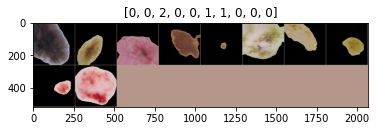

In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(data)

imshow(out, title=[x.item() for x in label])

### Training

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/4 channel classification/densenest_wce_adam_masked.txt", level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/MRTYUTeam/Tensorboard/Classification/4 channel classification'

In [ ]:
# Parameters 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Device used
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 10

EPOCHS = 100
WD = 1e-8

In [ ]:
class_weights = torch.tensor([0.4859, 1.7825, 2.6247]).to(DEVICE)

In [ ]:
densenet = make_densenet2(True)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(densenet.parameters(), lr = LR, weight_decay=WD)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.5, mode="min")

In [ ]:
logging.info('Model:Densenet, LR: 1e-4, LR patience = 7, loss: WCE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8, Masked images')

Model:Densenet, LR: 1e-4, LR patience = 7, loss: WCE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8, Masked images


In [ ]:
densenet = train_model(densenet, dataloaders, criterion, optimizer, lr_scheduler, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
----------
train epoch 1 : loss : 0.9598, acc: 0.5580, bma: 0.5368
val epoch 1 : loss : 0.8296, acc: 0.6067, bma: 0.5781

Epoch 2/100
----------
train epoch 2 : loss : 0.8813, acc: 0.5935, bma: 0.5847
val epoch 2 : loss : 0.7855, acc: 0.6733, bma: 0.6162

Epoch 3/100
----------
train epoch 3 : loss : 0.8286, acc: 0.6350, bma: 0.6387
val epoch 3 : loss : 0.6787, acc: 0.6933, bma: 0.6589

Epoch 4/100
----------
train epoch 4 : loss : 0.7913, acc: 0.6520, bma: 0.6465
val epoch 4 : loss : 0.5922, acc: 0.7267, bma: 0.7208

Epoch 5/100
----------
train epoch 5 : loss : 0.7646, acc: 0.6580, bma: 0.6633
val epoch 5 : loss : 0.6648, acc: 0.7267, bma: 0.7186

Epoch 6/100
----------
train epoch 6 : loss : 0.7316, acc: 0.6830, bma: 0.6777
val epoch 6 : loss : 0.5837, acc: 0.6867, bma: 0.6846

Epoch 7/100
----------
train epoch 7 : loss : 0.7428, acc: 0.6780, bma: 0.6731
val epoch 7 : loss : 0.6808, acc: 0.7400, bma: 0.7042

Epoch 8/100
----------
train epoch 8 : loss : 0.7177, acc: 0.7

### Test

In [ ]:
test_loss, test_acc, test_bma = test_model(densenet, test_loader, DEVICE, criterion)

Test Loss: 0.8141 Acc: 0.6050, BMA: 0.6975
Testing complete in 15m 20s


In [ ]:
logging.info('Test loss: %.4f, acc: %.4f, bma: %.4f' % (test_loss, test_acc, test_bma))

Test loss: 0.8141, acc: 0.6050, bma: 0.6975


Show some results

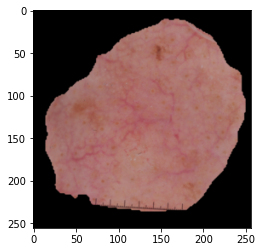

Actual: 2, predicted: 2


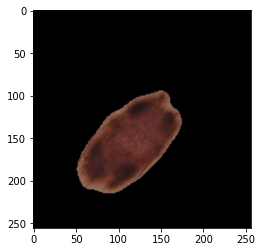

Actual: 0, predicted: 1


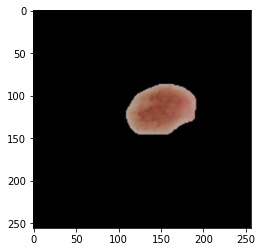

Actual: 0, predicted: 0


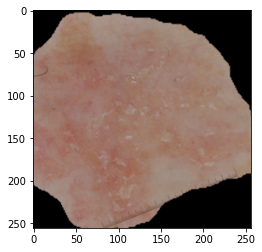

Actual: 2, predicted: 2


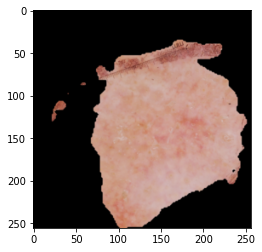

Actual: 2, predicted: 2


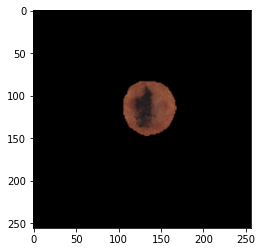

Actual: 0, predicted: 2


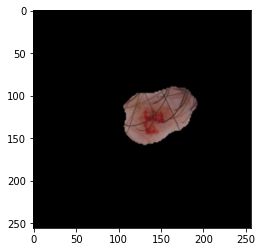

Actual: 0, predicted: 2


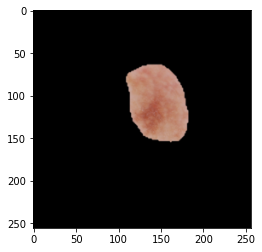

Actual: 0, predicted: 1


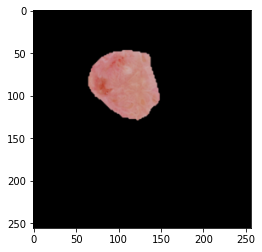

Actual: 2, predicted: 2


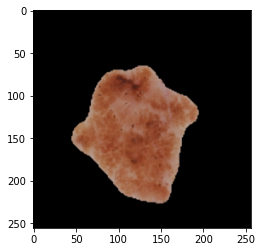

Actual: 2, predicted: 1


In [ ]:
visualize_model(densenet, test_loader, DEVICE, num_images=10)

# Best model evaluation

In [ ]:
densenet = make_densenet(False)
densenet.load_state_dict(torch.load('/content/drive/MyDrive/Project Report/Checkpoints/Classification/4c_densenet_wce_adam_best.pth'))

<All keys matched successfully>

In [ ]:
outputs, labels, preds = test_model2(densenet, test_loader)

In [ ]:
acc = accuracy_score(labels, preds)
bma = balanced_accuracy_score(labels, preds)
cm = confusion_matrix(labels, preds)
prec = precision_score(labels, preds, average='macro')
rec = recall_score(labels, preds, average='macro') 

print(f"Accuracy: \t{acc:.4f}")
print(f"BMA: \t\t{bma:.4f}")
print(f"Precision: \t{prec:.4f}")
print(f"Recall: \t{rec:.4f}")

cm

Accuracy: 	0.7767
BMA: 		0.7766
Precision: 	0.7033
Recall: 	0.7766


array([[310,  47,  36],
       [ 23,  75,  19],
       [  6,   3,  81]])

In [ ]:
acc_benin = 310.0/(310.0 + 47.0 + 36.0)
acc_melanoma = 75.0/(75.0 + 23.0+19.0)
acc_keratosis = 81.0/(81.0 + 6.0 + 3.0)

print(f'Acc for benin: {acc_benin:.5f}')
print(f'Acc for melanoma: {acc_melanoma:.5f}')
print(f'Acc for keratosis: {acc_keratosis:.5f}')

Acc for benin: 0.78880
Acc for melanoma: 0.64103
Acc for keratosis: 0.90000


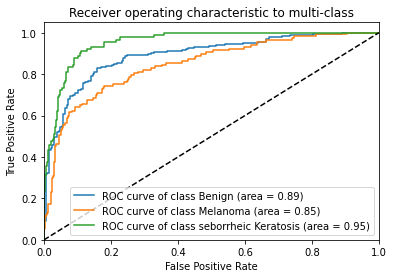

In [ ]:
plot_roc(labels, outputs, 3)

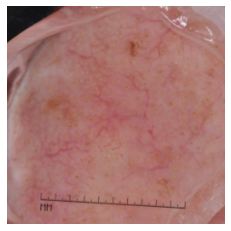

Actual: 2, predicted: 2


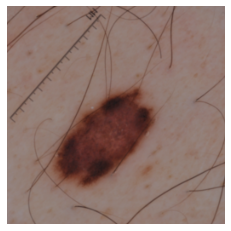

Actual: 0, predicted: 1


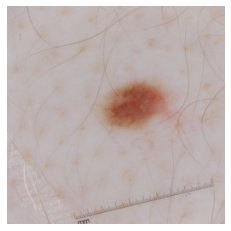

Actual: 0, predicted: 0


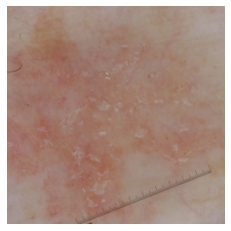

Actual: 2, predicted: 2


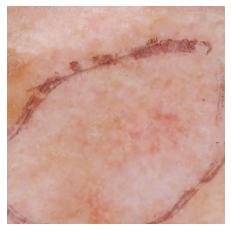

Actual: 2, predicted: 2


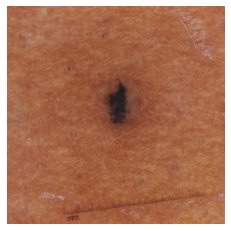

Actual: 0, predicted: 0


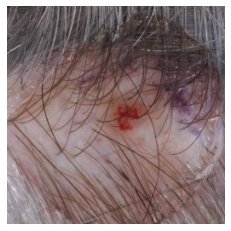

Actual: 0, predicted: 2


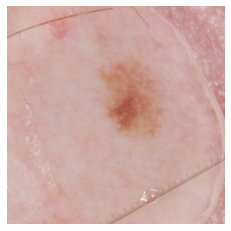

Actual: 0, predicted: 0


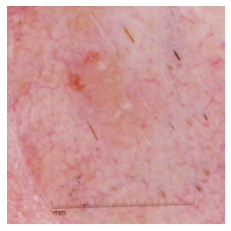

Actual: 2, predicted: 2


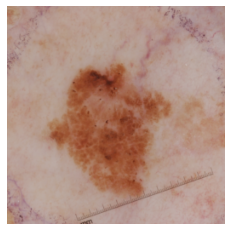

Actual: 2, predicted: 2


In [ ]:
visualize_model(densenet, test_loader, 'cuda', 10)